# Forward simulations 

In this notebook, we use a synthetic example to explore aspects of numerical modelling, including mesh design, as well as exploring aspects of the fundamental physics, including viewing the currents, charges and potentials from conductive and resistive targets. 

## Step 0: Imports and load survey info

These initial steps are the same as in the previous notebook. 

In [1]:
# core python 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm, Normalize
import ipywidgets

# tools in the simPEG Ecosystem 
import discretize  # for creating computational meshes

# SimPEG inversion machinery
from simpeg import Data, maps
from simpeg.utils.solver_utils import get_default_solver

# DC resistivity and IP modules
from simpeg.electromagnetics import resistivity as dc
from simpeg.electromagnetics.static.utils import (
    plot_pseudosection,
    apparent_resistivity_from_voltage,
)

# our own data importer 
from my_utils import read_dcip_data

In [2]:
# set the font size in the plots
from matplotlib import rcParams
rcParams["font.size"] = 12

In [3]:
# set the solver as default solver 
Solver = get_default_solver()

## Step 1: Load DC survey

As in the first notebook, we load up the survey geometry from our data file and create a SimPEG survey object.  

In [4]:
line = "46800E"

dc_data_file = f"./century/{line}/{line[:-1]}POT.OBS"

In [5]:
dc_data_dict = read_dcip_data(dc_data_file, verbose=False)

In [6]:
# initialize an empty list for each 
source_list = []

# center the survey and work in local coordinates
x_local = 0.5*(np.min(dc_data_dict["a_locations"]) + np.max(np.hstack(dc_data_dict["n_locations"])))

for i in range(dc_data_dict["n_sources"]):
    
    # receiver electrode locations in 2D 
    m_locs = np.vstack([
        dc_data_dict["m_locations"][i] - x_local, 
        np.zeros_like(dc_data_dict["m_locations"][i])
    ]).T
    n_locs = np.vstack([
        dc_data_dict["n_locations"][i] - x_local,
        np.zeros_like(dc_data_dict["n_locations"][i])
    ]).T
    
    # construct the receiver object 
    receivers = dc.receivers.Dipole(locations_m=m_locs, locations_n=n_locs, storeProjections=False)
    
    # construct the source 
    source = dc.sources.Dipole(
        location_a=np.r_[dc_data_dict["a_locations"][i] - x_local, 0.],
        location_b=np.r_[dc_data_dict["b_locations"][i] - x_local, 0.],
        receiver_list=[receivers]
    )
    
    # append the new source to the source list
    source_list.append(source)

In [7]:
survey = dc.Survey(source_list=source_list)

## Exploration 1: how does mesh design impact accuracy? 

In what follows, we will build up several functions that allow us to design a mesh and compare the simulated apparent resistivity and the true half-space resistivity in order to assess the mesh design. 

In [8]:
def build_mesh(
    survey, 
    n_cells_per_spacing_x=4,
    n_cells_per_spacing_z=4,
    n_core_extra_x=4,
    n_core_extra_z=4,
    core_domain_z_ratio=1/3.,
    padding_factor=1.3,
    n_pad_x=10,
    n_pad_z=10,
):
    """
    A function for designing a Tensor Mesh based on DC survey parameters
    
    Parameters
    ----------
    
    survey: dc.Survey 
        A DC (or IP) survey object
    
    n_cells_per_spacing_[x, z]: int
        Number of [x, z]-cells per the minimum electrode spacing
        
    n_core_extra_[x, z]: int
        Number of extra cells with the same size as the core domain beyond the survey extent
    
    core_domain_z_ratio: float
        Factor that multiplies the maximum AB, MN separation to define the core mesh extent
    
    padding_factor: float
        Factor by which we expand the mesh cells in the padding region
    
    n_pad_[x, z]: int
        Number of padding cells in the x, z directions
    """
    min_electrode_spacing = np.min(np.abs(survey.locations_a[:, 0] - survey.locations_b[:, 0]))

    dx = min_electrode_spacing / n_cells_per_spacing_x
    dz = min_electrode_spacing / n_cells_per_spacing_z
    
    # define the x core domain
    core_domain_x = np.r_[
        survey.unique_electrode_locations[:, 0].min(),
        survey.unique_electrode_locations[:, 0].max()
    ]
    
    # find the y core domain
    # find the maximum spacing between source, receiver midpoints
    mid_ab = (survey.locations_a + survey.locations_b)/2
    mid_mn = (survey.locations_m + survey.locations_n)/2
    separation_ab_mn = np.abs(mid_ab - mid_mn)
    max_separation = separation_ab_mn.max()
    core_domain_z = np.r_[-core_domain_z_ratio * max_separation, 0.]
    
    # add extra cells beyond the core domain
    n_core_x = np.ceil(np.diff(core_domain_x)/dx) + n_core_extra_x*2  # on each side
    n_core_z = np.ceil(np.diff(core_domain_z)/dz) + n_core_extra_z  # just below
    
    # define the tensors in each dimension
    hx = [(dx, n_pad_x, -padding_factor), (dx, n_core_x), (dx, n_pad_x, padding_factor)]
    hz = [(dz, n_pad_z, -padding_factor), (dz, n_core_z)]

    mesh = discretize.TensorMesh([hx, hz], x0="CN")

    return mesh, core_domain_x, core_domain_z

<Axes: xlabel='x1', ylabel='x2'>

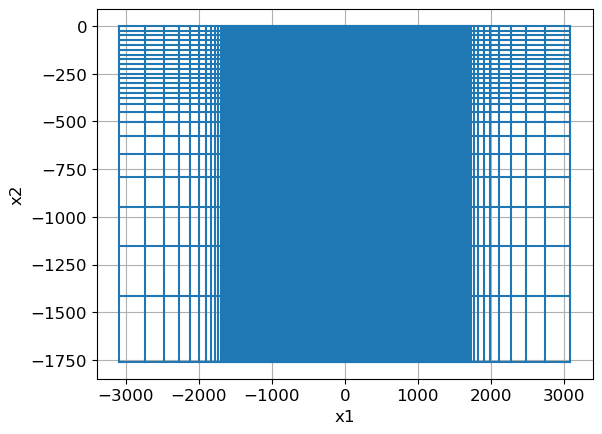

In [9]:
mesh, core_domain_x, core_domain_z = build_mesh(survey)
mesh.plot_grid()

In [10]:
mesh

TensorMesh: 3,900 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    156     -3,085.13      3,085.13     25.00    344.65    1.30
   y     25     -1,760.13          0.00     25.00    344.65    1.30

In [11]:
def forward_simulation_halfspace(mesh, survey=survey, resistivity=100, nky=11):
    """
    A function that  returns predicted data given a mesh, survey, 
    resistivity value and number of filters for the 2.5 DC simulation. 
    """
    # clear the stored source values if they were previously computed 
    for src in survey.source_list:
        src._q = None
        
    rho = resistivity * np.ones(mesh.nC)
    simulation_dc = dc.Simulation2DNodal(
        mesh, rhoMap=maps.IdentityMap(mesh), solver=Solver, 
        survey=survey, nky=nky
    )
    dpred = simulation_dc.make_synthetic_data(rho)
    
    # clear the stored source values if they were previously computed 
    for src in survey.source_list:
        src._q = None
    
    return dpred

In [12]:
def plot_apparent_resistivities(dpred, halfspace_resistivity):
    """
    Plot the apparent resistivity given a SimPEG data object 
    and the true halfspace resistivity. 

    """
    
    # plot psuedosection
    fig = plt.figure(constrained_layout=True, figsize=(12, 4))
    gs = fig.add_gridspec(ncols=3, nrows=1)

    ax0 = fig.add_subplot(gs[:2])
    ax1 = fig.add_subplot(gs[2])

    # plot the pseudosection
    rhoa_plot = apparent_resistivity_from_voltage(dpred.survey, dpred.dobs)
    plot_pseudosection(
        dpred, dobs=rhoa_plot, # clim=clim,
        data_locations=True, ax=ax0, 
        cbar_label="Apparent Resistivities ($\Omega$m)"
    )
    ax0.set_aspect(2)  # some vertical exxageration
    ax0.set_title(f"{line} Pseudosection")
    ax0.set_xlabel("Northing (m)")
    ax0.set_yticks([])

    # plot the errors in apparent resistivity relative to separation
    mid_ab = (survey.locations_a + survey.locations_b)/2
    mid_mn = (survey.locations_m + survey.locations_n)/2
    separation_ab_mn = np.abs(mid_ab - mid_mn)
    apparent_resistivity = apparent_resistivity_from_voltage(dpred.survey, dpred.dobs)
    percent_error = (apparent_resistivity - halfspace_resistivity)/halfspace_resistivity*100

    ax1.plot(separation_ab_mn[:, 0], percent_error, '.', alpha=0.4)
    ax1.set_xlabel("AB - MN separation")
    ax1.set_ylabel("percent difference (%)")
    ax1.set_title("Error in apparent resistivities")
    ax1.grid(alpha=0.3)


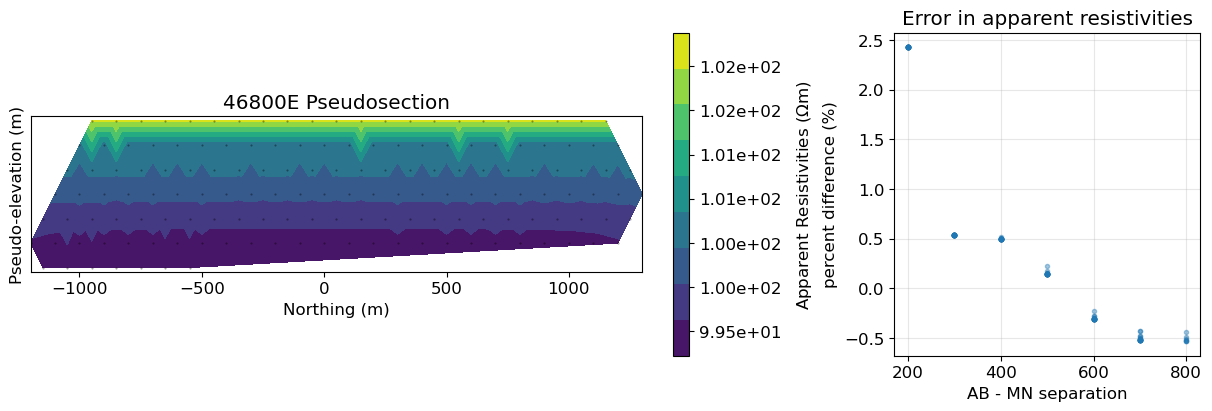

In [13]:
halfspace_resistivity = 100
dpred = forward_simulation_halfspace(mesh, resistivity=halfspace_resistivity)
plot_apparent_resistivities(dpred, halfspace_resistivity)

In [14]:
def mesh_design_simulator(
    survey=survey, 
    n_cells_per_spacing_x=4,
    n_cells_per_spacing_z=4,
    n_core_extra_x=4,
    n_core_extra_z=4,
    core_domain_z_ratio=1/3.,
    padding_factor=1.3,
    n_pad_x=10,
    n_pad_z=10,
    log10_halfspace_resistivity=2,
    nky=11,
):
    """
    A function that brings together mesh design and forward simulation so 
    that we can interactively explore factors of mesh design that influence 
    the accuracy of our simulation. 
    """
    
    # set up mesh 
    mesh, core_domain_x, core_domain_z = build_mesh(
        survey=survey, 
        n_cells_per_spacing_x=n_cells_per_spacing_x,
        n_cells_per_spacing_z=n_cells_per_spacing_z,
        n_core_extra_x=n_core_extra_x,
        n_core_extra_z=n_core_extra_z,
        core_domain_z_ratio=core_domain_z_ratio,
        padding_factor=padding_factor,
        n_pad_x=n_pad_x,
        n_pad_z=n_pad_z,
    )
    
    # convert the log10 resistivity to true resistivity on the mesh
    halfspace_resistivity = 10**log10_halfspace_resistivity 
    
    # compute predicted data
    dpred = forward_simulation_halfspace(mesh, resistivity=halfspace_resistivity, nky=nky)
    
    # plot those apparent resistivities 
    plot_apparent_resistivities(dpred, halfspace_resistivity)

In [15]:
mesh_design_app = ipywidgets.interactive(
    mesh_design_simulator,
    survey=ipywidgets.fixed(survey),
    n_cells_per_spacing_x=ipywidgets.IntSlider(
        description="nCx p. 100m", min=1, max=10, value=4, continuous_update=False
    ),
    n_cells_per_spacing_z=ipywidgets.IntSlider(
        description="nCz p. 100m", min=1, max=10, value=4, continuous_update=False
    ),
    n_core_extra_x=ipywidgets.IntSlider(
        description="ncore x +", min=0, max=10, value=4, continuous_update=False
    ),
    n_core_extra_z=ipywidgets.IntSlider(
        description="ncore z +", min=0, max=10, value=4, continuous_update=False
    ),
    core_domain_z_ratio=ipywidgets.FloatSlider(
        description="Dz*maxABMN", min=0.1, max=1, value=0.3, continuous_update=False
    ),
    padding_factor=ipywidgets.FloatSlider(
        description="pad factor", min=1, max=5, value=1.3, continuous_update=False
    ),
    n_pad_x=ipywidgets.IntSlider(
        min=1, max=20, value=10, continuous_update=False
    ),
    n_pad_z=ipywidgets.IntSlider(
        min=1, max=20, value=10, continuous_update=False
    ),
    log10_halfspace_resistivity=ipywidgets.FloatSlider(
        description="$log_{10}\\rho$", min=-1, max=7, value=2, continuous_update=False
    ),
    nky=ipywidgets.IntSlider(
        min=1, max=20, value=11, continuous_update=False
    )
)

#### Questions: Mesh design

- Which offsets are most affected if we change the number of cells per electrode spacing (the sliders labeled: `nCx p. 100m`, `nCz p. 100m`)?
- What about if we change the padding? 
- What happens if we reduce the number of padding cells but increase the padding factor? 

In [16]:
mesh_design_app

interactive(children=(IntSlider(value=4, continuous_update=False, description='nCx p. 100m', max=10, min=1), I…

## Exploration 2: the physics

Forward simulations can be a powerful tool for building up understanding and intuition for a given geophysical experiment. In SimPEG, we expose the ability to access the fields and fluxes computed in a simulation through the `fields` object that contains the solution to the PDE everywhere on the mesh. This is an intermediate step when computing predicted data, and in an inversion, we would typically not store them. 

Here, we build up a simple synthetic model that includes 2 blocks, one resistive and one conductive, in a halfspace. We will visualize the currents, charges and electric fields. 

### Define the model

In [17]:
# define the resistivities
rho_background = 100
rho_resistive_block = 1000
rho_conductive_block = 10

# define the geometry of each block
xlim_resistive_block = np.r_[-500, -250]
zlim_resistive_block = np.r_[-250, -100]

xlim_conductive_block = np.r_[250, 500]
zlim_conductive_block = np.r_[-250, -100]

### Put the model on the mesh

For the simulation, we define physical properties on the cell centers of the mesh. In `discretize`, once we have created a mesh, the cell-centered grid is accessible through the `gridCC` property. Columns correspond to each of the dimensions, so the shape of `gridCC` is (number of cells, number of dimensions). 

In [18]:
rho = rho_background * np.ones(mesh.nC)

# resistive block
inds_resistive_block = (
    (mesh.gridCC[:, 0] >= xlim_resistive_block.min()) & (mesh.gridCC[:, 0] <= xlim_resistive_block.max()) &
    (mesh.gridCC[:, 1] >= zlim_resistive_block.min()) & (mesh.gridCC[:, 1] <= zlim_resistive_block.max())
)

rho[inds_resistive_block] = rho_resistive_block

# conductive block
inds_conductive_block = (
    (mesh.gridCC[:, 0] >= xlim_conductive_block.min()) & (mesh.gridCC[:, 0] <= xlim_conductive_block.max()) &
    (mesh.gridCC[:, 1] >= zlim_conductive_block.min()) & (mesh.gridCC[:, 1] <= zlim_conductive_block.max())
)

rho[inds_conductive_block] = rho_conductive_block

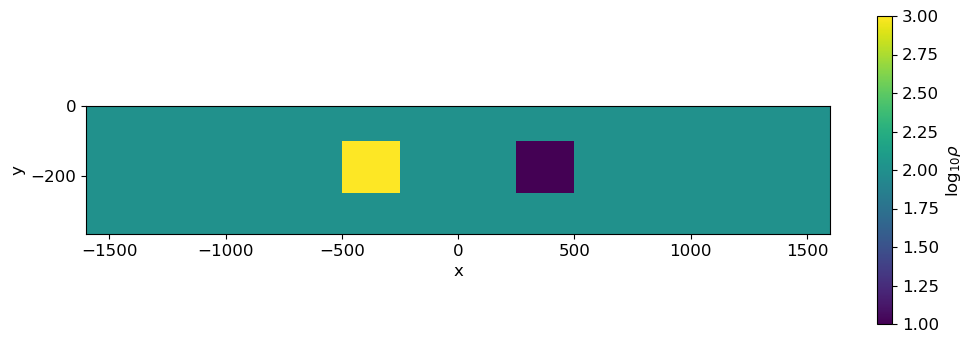

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
out = mesh.plot_image(np.log10(rho), ax=ax)
plt.colorbar(out[0], ax=ax, label="log$_{10} \\rho$")
ax.set_xlim(core_domain_x)
ax.set_ylim(core_domain_z + np.r_[-100, 0])
ax.set_aspect(1.5)

### Set up the forward simulation

As in the [previous notebook](1-century-dcip-inversion.ipynb), we set up a forward simulation. In this case, we use an `IdentityMap` for the mapping, so we directly provide resistivity values to the forward simulation. In order to be able to explore the impact of both the blocks on our measured data, we will run simulations for both the halfspace background and for the model containing two blocks. 

In [20]:
mapping = maps.IdentityMap(mesh)

# Generate 2.5D DC problem
simulation_dc = dc.Simulation2DNodal(
    mesh, rhoMap=mapping, solver=Solver, survey=survey
)

In [21]:
%%time 

# run the forward simulation over the half-space 
model_background = rho_background * np.ones(mesh.nC)
fields_background = simulation_dc.fields(model_background)
synthetic_data_background = simulation_dc.make_synthetic_data(model_background, f=fields_background)

CPU times: user 1.16 s, sys: 164 ms, total: 1.33 s
Wall time: 319 ms


In [22]:
%%time 

# run the forward simulation over the full model
fields = simulation_dc.fields(rho)
synthetic_data = simulation_dc.make_synthetic_data(rho, f=fields)

CPU times: user 1.66 s, sys: 169 ms, total: 1.83 s
Wall time: 364 ms


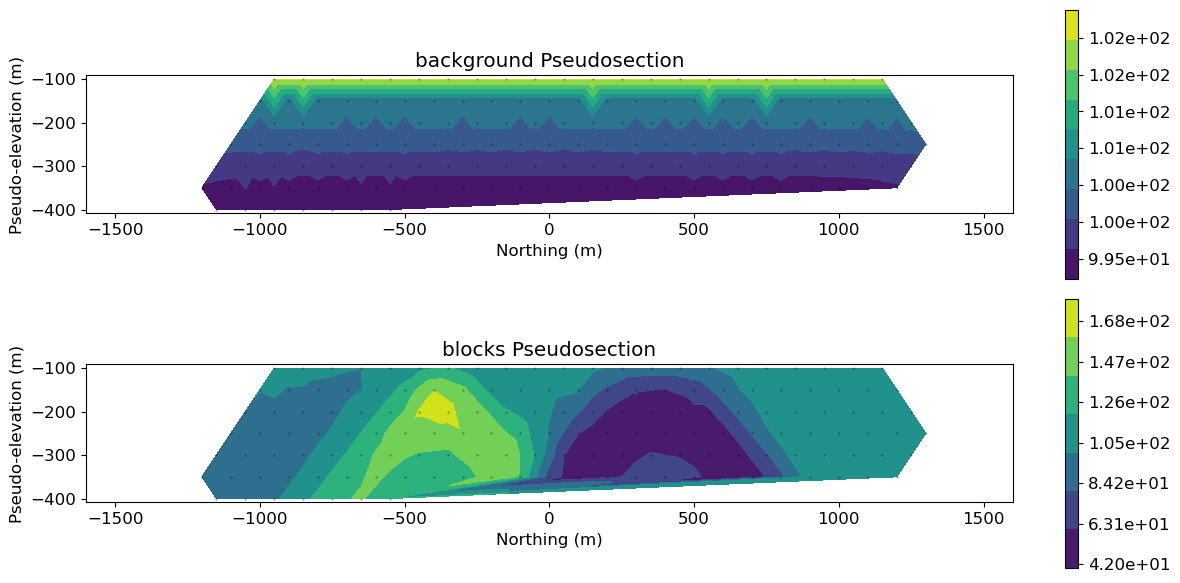

In [23]:
# plot both pseudosections 
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

for a, plot_data, title in zip(
    ax, [synthetic_data_background, synthetic_data], ["background", "blocks"]
):
    
    # plot a psuedosection of the data
    rhoa_plot = apparent_resistivity_from_voltage(plot_data.survey, plot_data.dobs)
    plot_pseudosection(
        plot_data, rhoa_plot,
        data_locations=True, ax=a, 
    )
    a.set_title(f"{title} Pseudosection")
    a.set_xlim(core_domain_x)
    a.set_aspect(1.5)  # some vertical exxageration
    a.set_xlabel("Northing (m)")

plt.tight_layout()


### Define a plotting function to visualize aspects of the physics

In a Nodal discretization for the DC problem: 
- physical properties are at cell centers (CC)
- charge density is at cell centers (CC)
- electric potentials (`phi`) are at cell nodes (N)
- electric fields (`e`) are on cell edges (E)
- current density (`j`) is on cell edges (E)

For plotting purposes, we will average to cell centers. To average the scalar `phi` values from nodes to cell centers, we use the `aveN2CC` operator. To average vector quantities (`e`, `j`) to cell centers, we use the `aveE2CCV` operator (`V` for vector). 


In [24]:
def plot_physics(field="phi", primsec="total", scale="linear", source_ind=0):
    """
    A function for plotting aspects of the forward simulation
    """
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))
    
    pcolor_opts = {}
    view = "real" 
    v_type = "CC"

    ylim = core_domain_z + np.r_[-100, 0]
    
    source = survey.source_list[source_ind]
    
    # plotting resistivities
    if field == "model":
        plotme = rho
        if primsec == "primary":
            plotme = model_background
        elif primsec == "secondary":
            plotme = plotme - model_background
        
        if scale.lower() == "log":
            pcolor_opts["norm"] = LogNorm()
            
    # plotting the physics
    else:
        if primsec in ["total", "secondary"]:
            plotme = fields[source, field]
            if primsec == "secondary":
                plotme -= fields_background[source, field]
        else:
            plotme = fields_background[source, field]
                
        # average the potentials to cell centers from Nodes
        if field == "phi": 
            plotme = mesh.aveN2CC * plotme
            
        # average the fields to cell centers
        elif field in ["j", "e"]:
            view = "vec"
            v_type = "CCv"
            plotme = mesh.aveE2CCV * plotme
            
            if scale.lower() == "log":
                pcolor_opts["norm"] = LogNorm()
        
        # set an intuitive colorbar for charges
        elif field == "charge_density":
            pcolor_opts["cmap"] = "RdBu_r"
        
        # set a symmetric colorbar
        if field in ["phi", "charge_density"]:
            max_abs = np.abs(plotme).max()
            if scale.lower() == "linear":
                pcolor_opts["norm"] = Normalize(vmin=-max_abs, vmax=max_abs)
            if scale.lower() == "log": 
                pcolor_opts["norm"] = SymLogNorm(
                    linthresh=max_abs * 1e-3, vmin=-max_abs, vmax=max_abs
                )
    
    # plot the physics
    out = mesh.plot_image(
        plotme, view=view, v_type=v_type, pcolor_opts=pcolor_opts, ax=ax[0], 
        range_x=core_domain_x, range_y=ylim,
    )
    ax[0].plot([source.location_a[0], source.location_b[0]], np.r_[5, 5], "vC3", ms=8)
    ax[0].set_ylim(ylim)
    plt.colorbar(out[0], ax=ax[0], label=field, fraction=0.1, orientation="horizontal", pad=0.25)
    
    
    # plot a psuedosection of the data
    rhoa_plot = apparent_resistivity_from_voltage(synthetic_data.survey, synthetic_data.dobs)
    plot_pseudosection(
        synthetic_data, dobs=rhoa_plot,
        data_locations=True, ax=ax[1], 
    )
    ax[1].set_title(f"{line} Pseudosection")
    
    for a in ax: 
        a.set_xlim(core_domain_x)
        a.set_aspect(1.5)  # some vertical exxageration
        a.set_xlabel("Northing (m)")
    
    plt.tight_layout()

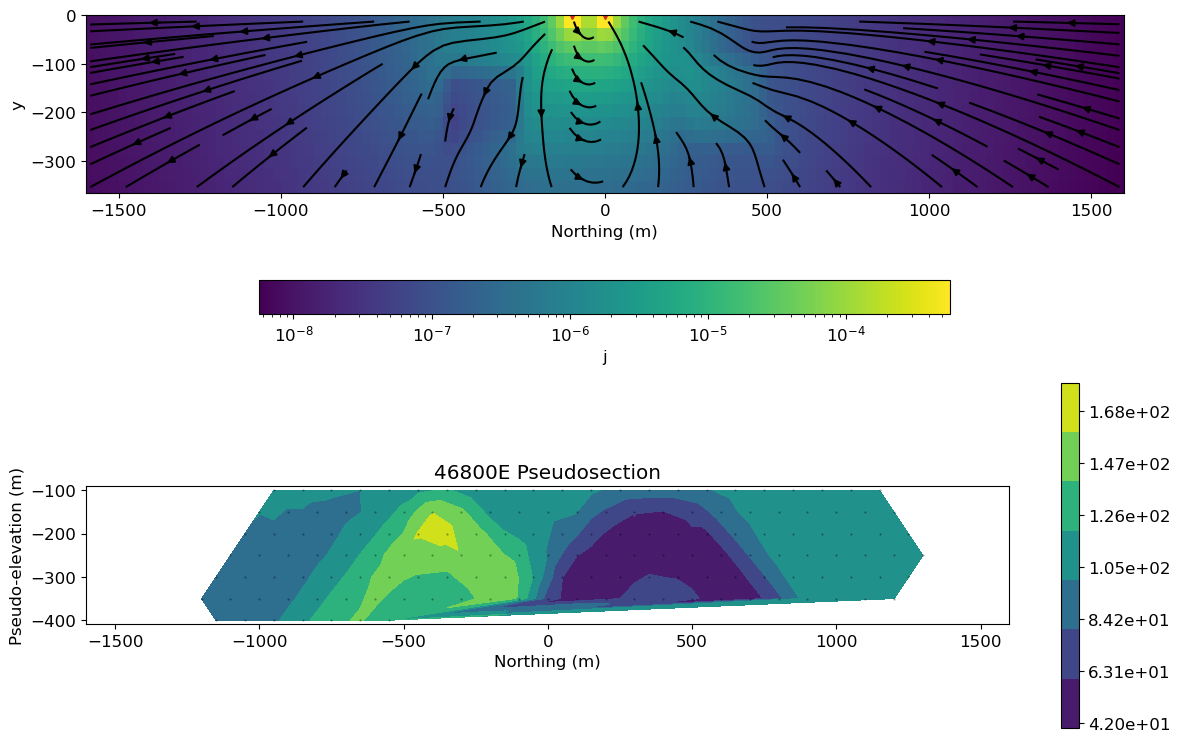

In [25]:
plot_physics(field="j", primsec="total", source_ind=15, scale="log")

In [26]:
dc_physics_app = ipywidgets.interactive(
    plot_physics,
    field=ipywidgets.ToggleButtons(options=["model", "j", "e", "charge_density", "phi"], value="model"),
    primsec=ipywidgets.ToggleButtons(options=["total", "primary", "secondary"], value="total"),
    scale=ipywidgets.ToggleButtons(options=["linear", "log"]),
    source_ind=ipywidgets.IntSlider(min=0, max=len(survey.source_list)-1, value=15),
)

#### Questions: Physics of DC

- Where do currents preferentially flow?
- Where do charges build up? How does that depend on the location of the source?


In [27]:
dc_physics_app

interactive(children=(ToggleButtons(description='field', options=('model', 'j', 'e', 'charge_density', 'phi'),…

## Homework ✏️

What happens if you introduce a layer above the blocks? 
- Define a layer from z=-50 to z=-100. 
- Start with a resistive layer. 
    - How does that change the currents? charges? 
    - Do we still see the evidence of the blocks in the data (Hint: compare those data with a model that contains the layer but not the block)
- Now try with a conductive layer.